In [1]:
import scipy.stats

In [4]:
cd /orange/adamginsburg/ALMA_IMF/2017.1.01355.L/

/orange/adamginsburg/ALMA_IMF/2017.1.01355.L


In [5]:
from astropy.table import Table

In [6]:
tbl = Table.read('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release/tables/metadata_image.tt0.ecsv')

In [7]:
tbl

region,band,array,selfcaliter,robust,suffix,bsens,pbcor,filename,bmaj,bmin,bpa,peak,sum,fluxsum,sumgt3sig,sumgt5sig,mad,mad_sample,std_sample,peak/mad,psf_secondpeak,psf_secondpeak_radius,psf_secondpeak_sidelobefraction,Req_Res,Req_Sens,SensVsReq,BeamVsReq
str8,str2,str7,str3,str4,str10,bool,bool,str194,float64,float64,float64,float32,float32,float64,float32,float32,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64
G333.60,B3,12Monly,sc6,r0.0,finaliter,False,True,/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release/G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.pbcor.fits,0.46611008048051994,0.4466926455498,39.20161819458,0.21592891,2134.8335,44.34027378890261,2064.2537,1884.0796,0.0002857776370690621,0.00024267075720414772,0.00032228354,755.5836572005758,0.23143493450778008,0.4668581494257094,0.4700982654933328,0.51,0.06,4.7629606178177015,0.8947021330213982
G333.60,B3,12Monly,sc0,r0.0,finalmodel,False,False,/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release/G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_preselfcal_finalmodel.image.tt0.fits,0.46611008048051994,0.4466926455498,39.20161819458,0.20720893,2179.8826,45.27593842122584,2280.9875,2123.0417,0.00022432151647173098,0.00011432685829669414,0.000120029654,923.7140275493275,0.23143493450778008,0.4668581494257094,0.4700982654933328,0.51,0.06,3.7386919411955164,0.8947021330213982
G333.60,B3,12Monly,sc0,r0.0,finalmodel,False,True,/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release/G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_preselfcal_finalmodel.image.tt0.pbcor.fits,0.46611008048051994,0.4466926455498,39.20161819458,0.20726733,2158.6794,44.83555167940237,2205.7058,1943.7828,0.000525420492748937,0.0003073295559850423,0.00041540826,394.47895915211893,0.23143493450778008,0.4668581494257094,0.4700982654933328,0.51,0.06,8.757008212482283,0.8947021330213982
G333.60,B3,12Monly,sc0,r0.0,preselfcal,False,False,/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release/G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_preselfcal.image.tt0.fits,0.46611008048051994,0.4466926455498,39.20161819458,0.20467064,1180.6073,24.521093099907972,2052.6116,1886.8055,0.00038559523872075597,0.0001655601192787586,0.00019111087,530.7914032471064,0.23143493450778008,0.4668581494257094,0.4700982654933328,0.51,0.06,6.426587312012599,0.8947021330213982
G333.60,B3,12Monly,sc0,r0.0,preselfcal,False,True,/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release/G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_preselfcal.image.tt0.pbcor.fits,0.46611008048051994,0.4466926455498,39.20161819458,0.20472832,1238.5618,25.724801479538673,2228.2593,1826.9983,0.0009040123675180437,0.00045363684287055123,0.00066278415,226.4662825388704,0.23143493450778008,0.4668581494257094,0.4700982654933328,0.51,0.06,15.066872791967395,0.8947021330213982
G333.60,B3,12Monly,sc6,r0.0,finaliter,False,False,/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release/G333.60/B3/cleanest/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_robust0_selfcal6_finaliter.image.tt0.fits,0.46611008048051994,0.4466926455498,39.20161819458,0.21586807,2060.217,42.790497633818276,2006.0898,1935.417,0.00012835928166983777,8.971093798665239e-05,9.457111e-05,1681.748821848943,0.23143493450778008,0.4668581494257094,0.4700982654933328,0.51,0.06,2.1393213611639625,0.8947021330213982
G333.60,B3,12Monly,sc0,r0.0,finalmodel,True,True,/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/February2021Release/G333.60/B3/bsens/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_bsens_12M_robust0_preselfcal_finalmodel.image.tt0.pbcor.fits,0.46619668602936004,0.44679495692268,39.22766494751,0.20863853,2178.6265,45.23108337905143,2231.3738,1974.8865,0.0004987713779348367,0.00026538822781

In [8]:
import glob

In [9]:
mslist = {(row['region'],row['band']): {'msname': glob.glob(f'/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/{row["region"]}_{row["band"]}*_12M_selfcal.ms'),
                                        'beam': (row['bmaj'], row['bmin'])}
          for row in tbl if row['robust'] == 'r0.0' and row['suffix'] == 'finaliter' and not row['bsens']}

In [10]:
from casatools import msmetadata, ms
from astropy import units as u

In [11]:
msmd = msmetadata()
ms = ms()

In [12]:
msmd.open('G351.77_B6_uid___A001_X1296_X201_continuum_merged_12M_selfcal.ms')
spws = msmd.spwsforfield('G351.77')
freqs = np.concatenate([msmd.chanfreqs(spw) for spw in spws])
freqweights = np.concatenate([msmd.chanfreqs(spw) for spw in spws])
freqs, freqweights
avfreq = np.average(freqs, weights=freqweights)
wavelength = (avfreq*u.Hz).to(u.m, u.spectral())

In [13]:
data = {}
for spw in spws:
    ms.open('G351.77_B6_uid___A001_X1296_X201_continuum_merged_12M_selfcal.ms')
    ms.selectinit(spw)
    data[spw] = ms.getdata(items=['weight', 'uvdist', 'flag'])
    ms.close()

ls paper_figures/

In [14]:
import pylab as pl
from astropy import units as u

In [15]:
beam = [0.89,0.67]*u.arcsec
beam_to_bl = (wavelength / beam).to(u.m, u.dimensionless_angles())
beam_to_bl

<Quantity [310.30506287, 412.19627754] m>

/home/adamginsburg/.local/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


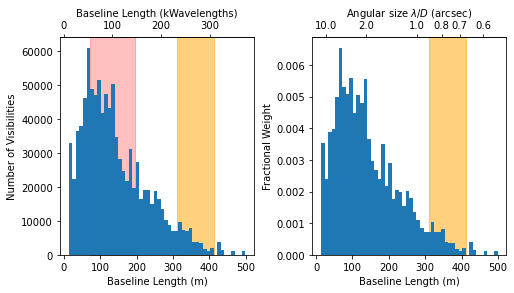

In [16]:
pl.figure(figsize=(8,4))
ax1 = pl.subplot(1,2,1)
bins = 50
uvcts = np.concatenate([data[spw]['uvdist'][~data[spw]['flag'].any(axis=(0,1))] for spw in data]).ravel()
_=pl.hist(uvcts, bins=bins)
_=pl.xlabel('Baseline Length (m)')
_=pl.ylabel("Number of Visibilities")
yl = pl.ylim()
pl.fill_betweenx(yl, beam_to_bl[0].value, beam_to_bl[1].value, zorder=-5, color='orange', alpha=0.5)
pl.fill_betweenx(yl, np.percentile(uvcts, 25), np.percentile(uvcts, 75), zorder=-5, color='red', alpha=0.25)
pl.ylim(yl)
ax1t = ax1.secondary_xaxis('top', functions=(lambda x: x/1e3/wavelength.to(u.m).value, lambda x:x/1e3/wavelength.to(u.m).value))
ax1t.set_xlabel("Baseline Length (kWavelengths)")
#ax1t.set_ticks(np.linspace(1000,100000,10))
ax2 = pl.subplot(1,2,2)
_=pl.hist(np.concatenate([data[spw]['uvdist'][~data[spw]['flag'].any(axis=(0,1))] for spw in data]).ravel(),
          weights=np.concatenate([data[spw]['weight'].mean(axis=0)[~data[spw]['flag'].any(axis=(0,1))] for spw in data]).ravel(),
          bins=bins, density=True)
_=pl.xlabel('Baseline Length (m)')
_=pl.ylabel("Fractional Weight")
def forward(x):
    return (wavelength.to(u.m)/(x*u.arcsec)).to(u.m, u.dimensionless_angles()).value
def inverse(x):
    return (wavelength.to(u.m)/(x*u.m)).to(u.arcsec, u.dimensionless_angles()).value
ax2t = ax2.secondary_xaxis('top', functions=(forward, inverse))
ax2t.set_xlabel("Angular size $\lambda/D$ (arcsec)")
ax2t.set_ticks([10,2,1,0.8,0.7,0.6])
yl = pl.ylim()
pl.fill_betweenx(yl, beam_to_bl[0].value, beam_to_bl[1].value, zorder=-5, color='orange', alpha=0.5)
pl.ylim(yl)
pl.subplots_adjust(wspace=0.3)

In [17]:
forward(300), inverse(300), forward(inverse(1)), forward(1)

(0.9205716865117204, 0.9205716865117204, 1.0, 276.17150595351615)

In [18]:
np.seterr('ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G333.60_B3_uid___A001_X1296_X1a3_continuum_merged_12M_selfcal.ms
25th pctile=5.883110597327858, 75th pctile=1.1882680026898285
[{'region': 'G333.60', 'band': 'B3', '1%': 34.99905733466402, '5%': 14.439818640344928, '10%': 10.111195912786126, '25%': 5.883110597327858, '50%': 2.7011745980381816, '75%': 1.1882680026898285, '90%': 0.677506242476233, '95%': 0.5239443828356729, '99%': 0.3946357098969859, 'beam_major': <Quantity 0.46611008 arcsec>, 'beam_minor': <Quantity 0.44669265 arcsec>, 'beam_major_pctile': 97.33162875884993, 'beam_minor_pctile': 97.99751203342886}]
/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/G333.60_B6_uid___A001_X1296_X19b_continuum_merged_12M_selfcal.ms
25th pctile=3.573667371460695, 75th pctile=1.0876888946896925
[{'region': 'G333.60', 'band': 'B3', '1%': 34.99905733466402, '5%': 14.439818640344928, '10%': 10.111195912786126, '25%': 5.883110597327858, '50%': 2.7011745980381816, '75%': 1.1882680026898285, '90%': 0.67750624

/orange/adamginsburg/ALMA_IMF/reduction/analysis/uvhistograms.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  pl.figure(figsize=(8,4))


25th pctile=5.369951467098543, 75th pctile=1.060694686919038
[{'region': 'G333.60', 'band': 'B3', '1%': 34.99905733466402, '5%': 14.439818640344928, '10%': 10.111195912786126, '25%': 5.883110597327858, '50%': 2.7011745980381816, '75%': 1.1882680026898285, '90%': 0.677506242476233, '95%': 0.5239443828356729, '99%': 0.3946357098969859, 'beam_major': <Quantity 0.46611008 arcsec>, 'beam_minor': <Quantity 0.44669265 arcsec>, 'beam_major_pctile': 97.33162875884993, 'beam_minor_pctile': 97.99751203342886}, {'region': 'G333.60', 'band': 'B6', '1%': 16.939583653167535, '5%': 8.195903799583645, '10%': 5.845982810419041, '25%': 3.573667371460695, '50%': 2.137539771893749, '75%': 1.0876888946896925, '90%': 0.7519548317514337, '95%': 0.6548934272537734, '99%': 0.4770690682615153, 'beam_major': <Quantity 0.58803159 arcsec>, 'beam_minor': <Quantity 0.52308249 arcsec>, 'beam_major_pctile': 96.94155475919537, 'beam_minor_pctile': 98.46610112173016}, {'region': 'G351.77', 'band': 'B3', '1%': 37.81796832

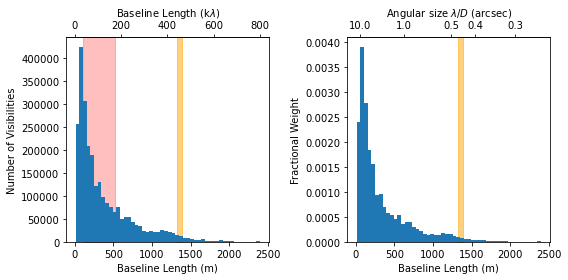

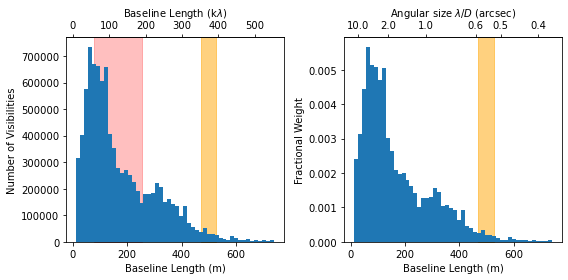

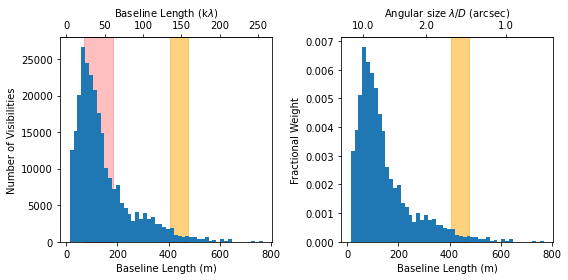

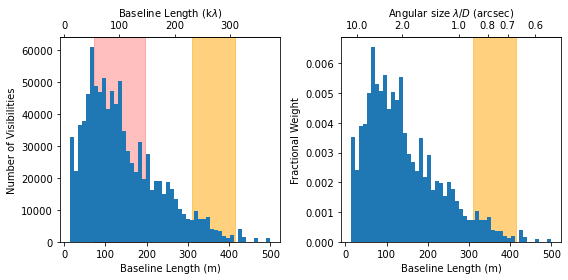

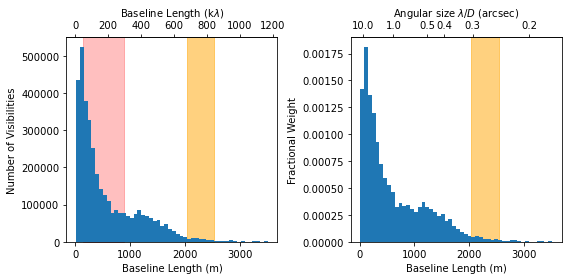

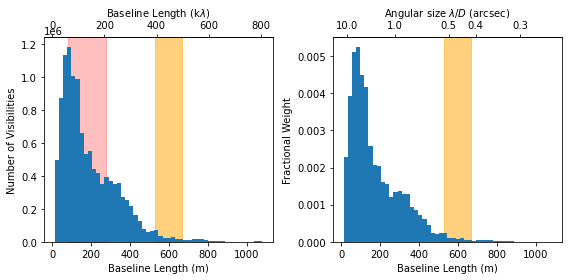

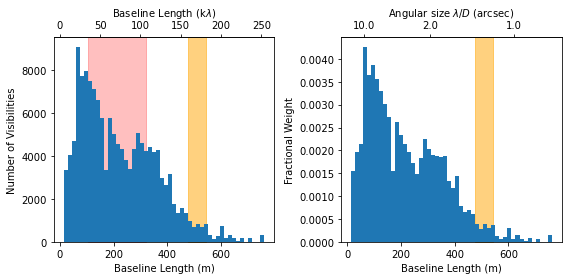

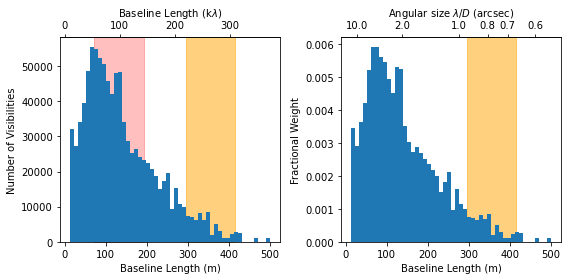

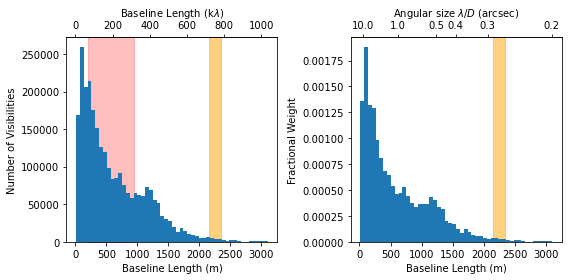

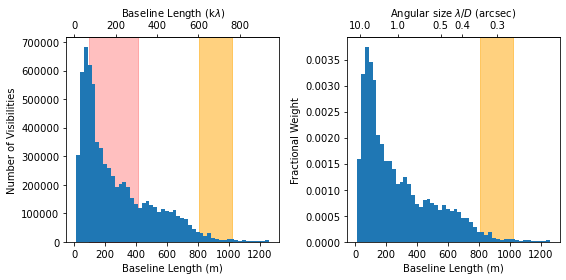

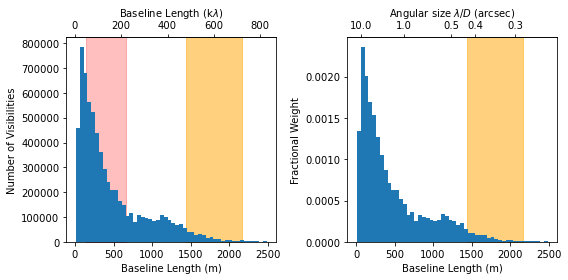

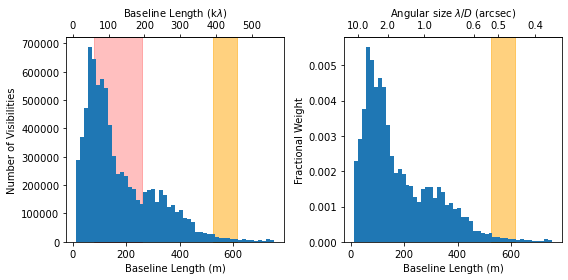

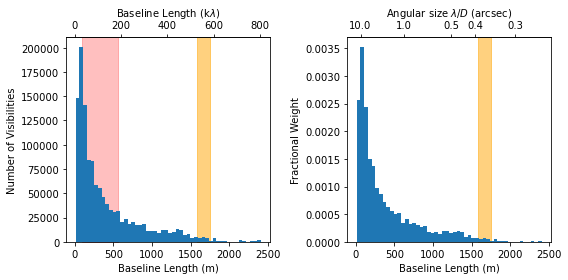

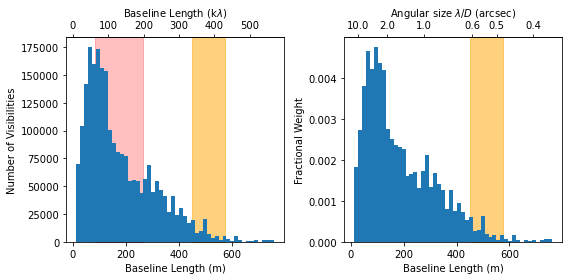

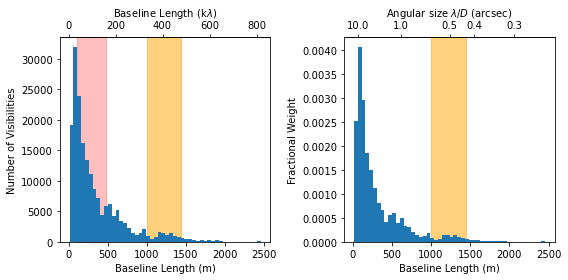

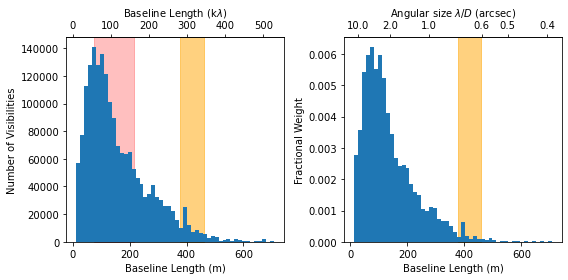

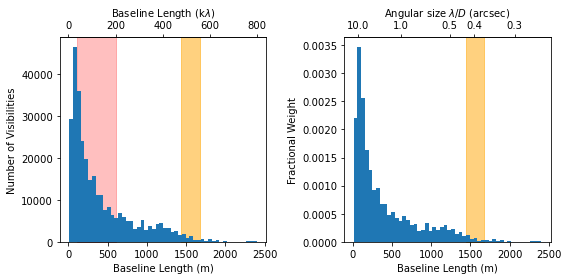

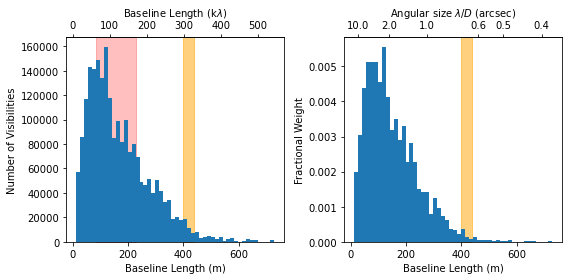

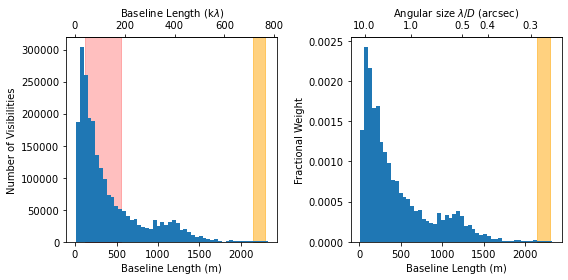

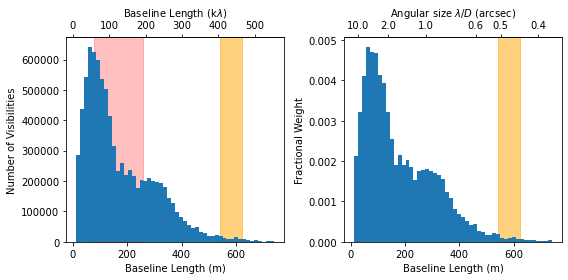

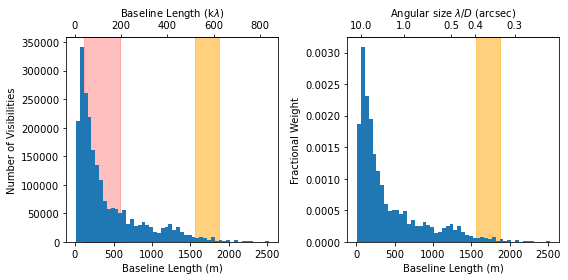

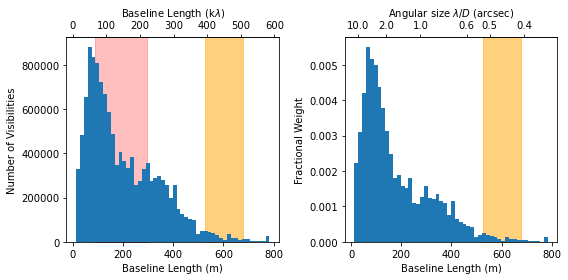

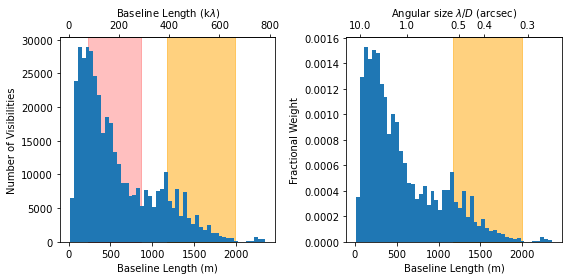

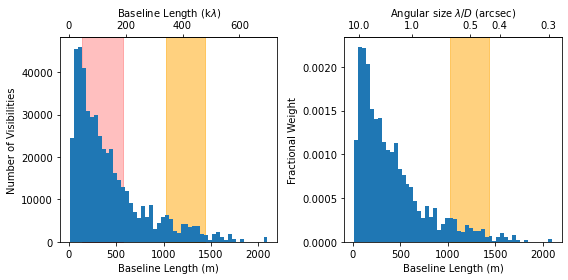

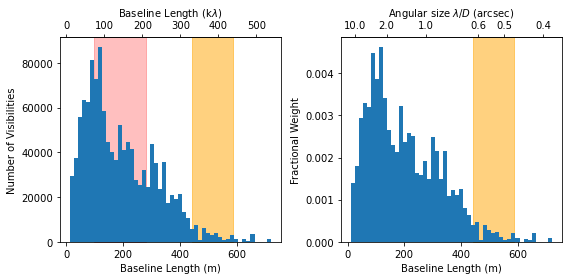

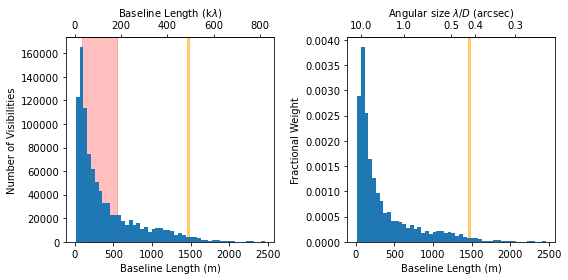

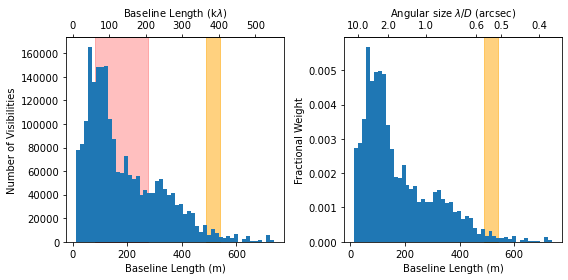

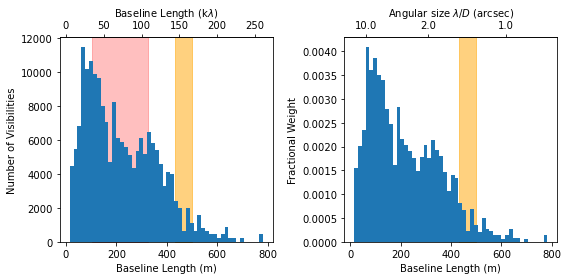

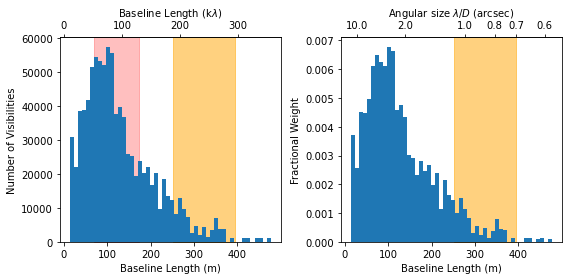

In [25]:
%run /orange/adamginsburg/ALMA_IMF/reduction/analysis/uvhistograms.py

In [26]:
uvtbl

1%,10%,25%,5%,50%,75%,90%,95%,99%,band,beam_major,beam_major_pctile,beam_minor,beam_minor_pctile,region
float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,object,float64,object,float64,str8
34.99905733466402,10.111195912786126,5.883110597327858,14.439818640344928,2.7011745980381816,1.1882680026898285,0.677506242476233,0.5239443828356729,0.3946357098969859,B3,0.46611008048051994 arcsec,97.33162875884993,0.4466926455498 arcsec,97.99751203342886,G333.60
16.939583653167535,5.845982810419041,3.573667371460695,8.195903799583645,2.137539771893749,1.0876888946896925,0.7519548317514337,0.6548934272537734,0.4770690682615153,B6,0.58803158998476 arcsec,96.94155475919537,0.52308249473556 arcsec,98.46610112173016,G333.60
37.81796832662817,14.681119991728856,8.916500557250265,20.933134739504982,5.587311251022812,3.376331911734403,2.006839825497568,1.6434676077868917,1.1781057483675017,B3,1.52214825153348 arcsec,96.4467841365808,1.29934000968948 arcsec,98.16477205242852,G351.77
17.43330113528242,6.173177243504105,3.7817099873063187,8.990575414401912,2.263170639593267,1.414906462804683,1.0155311059020316,0.8579980254811358,0.6869252026553644,B6,0.8904317617414799 arcsec,93.88387112919405,0.66721618175508 arcsec,99.22172009868223,G351.77
27.892651152288376,8.118714434817473,4.202590141719418,11.800036052631576,1.829862444639698,0.6903700150107285,0.43090688259790993,0.36503437171400777,0.2682207330214732,B3,0.304656147956844 arcsec,98.00863581053308,0.243525370955472 arcsec,99.48914961819841,W43-MM2
16.304565527461204,5.4796747274054045,3.3421814687873903,7.72791074235,1.9090036709433704,1.0094447840090115,0.7191503836062181,0.6126408950748655,0.4158566692888121,B6,0.52421331405636 arcsec,97.31537734610077,0.41492545604712 arcsec,99.00948928019035,W43-MM2
33.8594991735422,9.991461760315795,5.981175772877655,13.984204087110122,3.1720862709366724,1.9341445367466321,1.5132351462121678,1.311801669496952,1.0182575108743865,B3,1.30032145977012 arcsec,95.2630575676706,1.13808143138868 arcsec,97.82691574532977,G353.41
17.822925769346337,6.239570226064805,3.80147993901235,9.06201617106467,2.2883025617052275,1.4347683781165113,1.0195288426256517,0.8661293917661397,0.688949525024233,B6,0.93687140941632 arcsec,93.24416156995342,0.66503322124488 arcsec,99.26325559809723,G353.41
20.33146042656913,6.3374863566143125,3.027299140633369,9.424657315287872,1.366756638172187,0.6562071943001319,0.46693686538123014,0.39624289308816646,0.28796168678034034,B3,0.28711274266242004 arcsec,99.02664380754396,0.26407456398010803 arcsec,99.45566903465158,W51-E


In [ ]:
np.array(row['1%','5%','10%','25%','50%','75%','95%','99%']).view((float, 8))
np.array([x.value for x in row['beam_major','beam_minor']])

(0.0, 3.0)

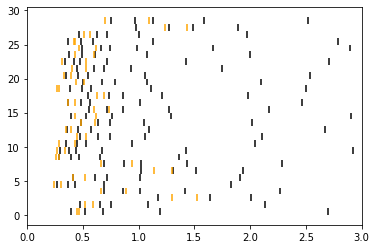

In [29]:
for ii, row in enumerate(uvtbl):
    pl.vlines(np.array(row['1%','5%','10%','25%','50%','75%','90%','95%','99%']).view((float, 9)),
              ii, ii+1, color='k')
    pl.vlines(np.array([x.value for x in row['beam_major','beam_minor']]), ii, ii+1, color='orange')
pl.xlim(0,3)

(array([ 1.,  0.,  1.,  1.,  2.,  2.,  2.,  7., 10.,  3.]),
 array([86.41106268, 87.75558835, 89.10011403, 90.4446397 , 91.78916537,
        93.13369104, 94.47821671, 95.82274238, 97.16726806, 98.51179373,
        99.8563194 ]),
 <BarContainer object of 10 artists>)

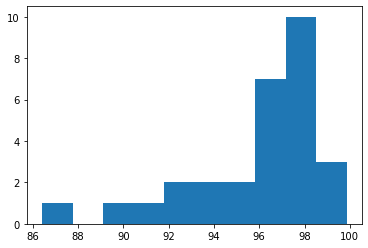

In [27]:
pl.hist(uvtbl['beam_major_pctile'])

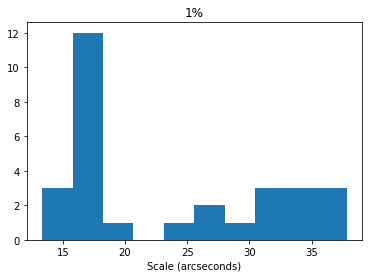

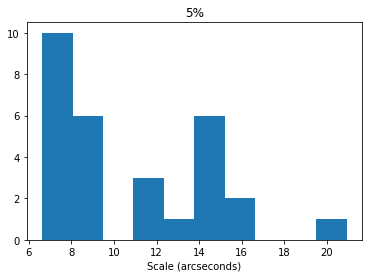

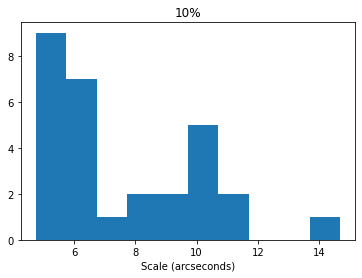

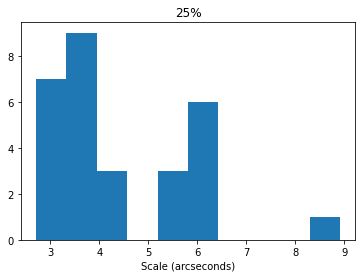

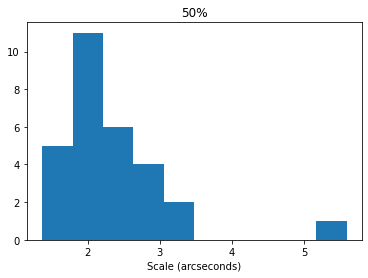

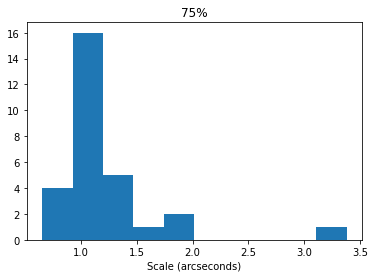

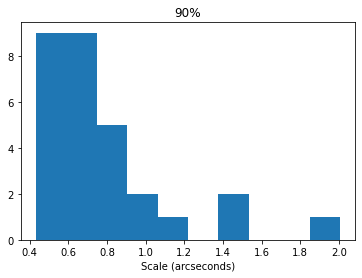

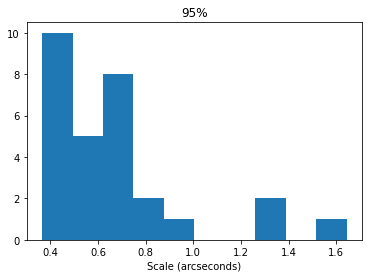

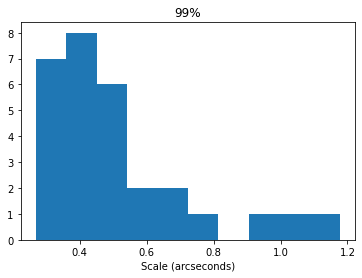

In [31]:
for pctile in ['1%','5%','10%','25%','50%','75%','90%','95%','99%']:
    pl.figure()
    pl.hist(uvtbl[pctile])
    pl.title(pctile)
    pl.xlabel("Scale (arcseconds)")